# The Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called camera_cal. The images in test_images are for testing your pipeline on single frames. If you want to extract more test images from the videos, you can simply use an image writing method like cv2.imwrite(), i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called output_images, and include a description in your writeup for the project of what each image shows. The video called project_video.mp4 is the video your pipeline should work well on.

The challenge_video.mp4 video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions. The harder_challenge.mp4 video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there! We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

## Import Libraries

In [50]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
import cv2
import os
import random
import pickle
%matplotlib inline
print("Packages imported!")
print("#########################################")

# Save mobile data usage by not showing images on screen. 
SW_SaveData = False

# Set variables correctly
if SW_SaveData == True:
    print("Switch 'SaveData' set to 'True': no images will be shown in Jupyter Notebook." )
    plt.ioff()
elif SW_SaveData == False:
    print("Switch 'SaveData' set to 'False': images will be shown on screen." )
    plt.ion()    


Packages imported!
#########################################
Switch 'SaveData' set to 'False': images will be shown on screen.


## Step 1: Camera calibration

### 1.a Cam Calibration: Helper function to calibrate camera from calibration images
This cell holds the function which reads in all .jpg files stored in a camera calibration directory (i.e. `./camera_cal`). 
The cv2 function to detect chessboard corners is being applied and all successfully processed image files with chessboard detection drawn as overlay are stored in directory `./output_images/chess*.jpg`. 
Finally, the camera undistortion coefficients are calculated and returned to the calling function.

In [2]:
# Read in camera calibration images
def camera_calibration(imgdir="./camera_cal", nx=9, ny=6, imgs_per_line=4):
    # Search in provided directory for jpg files
    print("###################################")
    print("STARTING CALIBRATION ROUTINE")
    # Prepare object point array, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    for root, dirs, files in os.walk(imgdir):
        # Print amount of files found
        print(np.size(files),"files found in directory.")
        # Calculate amount of lines for plotting image files
        n_lines = int(np.ceil(np.size(files)/imgs_per_line))
        n_cols = int(imgs_per_line)
        if SW_SaveData == False:
            fig, axs = plt.subplots(n_lines,n_cols)
            fig.set_figwidth(15)        
            fig.set_figheight(int(15/n_cols*n_lines*1.3/2)) 
        j = 0
        k = 0
        fail_count = 0
        pass_count = 0
        for file in files:
            if file.endswith(".jpg"):
                # Generate path to current file
                fname = os.path.join(root,file)
                # Read in image (CV2: BGR instead of RGB!)
                img = cv2.imread(fname)
                # Convert to grayscale
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                # Find the chessboard corners
                ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
                # If found, draw corners
                if ret == True:
                    # Draw chessboard corners on top of image
                    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                    # Write image file to harddrive
                    cv2.imwrite(("./output_images/cam_cal/chess_"+file),img)
                    # Append object and image points to arrays
                    objpoints.append(objp)
                    imgpoints.append(corners)
                    pass_count = pass_count + 1
                else:
                    fail_count = fail_count + 1

                # Show images on screen
                if SW_SaveData == False:
                    axs[j,k].imshow(img)
                k = k + 1
                if k == imgs_per_line:
                    k = 0
                    j = j + 1
    print(pass_count,"images PASSED. ",fail_count,"images FAILED")
    print("DETERMINING CALIBRATION COEFFICIENTS")
    
    # Do camera calibration with given object points and image points
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    # Print out calibration coefficients
    print("1. mtx:")
    print(mtx)
    print("2. dist:")
    print(dist)
    # Print successful ending of calibration routine
    print("CALIBRATION ROUTINE FINISHED")
    print("###################################")
    # Pass over calibration factors to calling function
    return (mtx,dist,img)

### 1.b  Cam Calibration: Determine camera undistortion factors

###################################
STARTING CALIBRATION ROUTINE
20 files found in directory.
0 files found in directory.
0 images PASSED.  0 images FAILED
DETERMINING CALIBRATION COEFFICIENTS
1. mtx:
[[1.15396093e+03 0.00000000e+00 6.69705357e+02]
 [0.00000000e+00 1.14802496e+03 3.85656234e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
2. dist:
[[-2.41017956e-01 -5.30721173e-02 -1.15810355e-03 -1.28318856e-04
   2.67125290e-02]]
CALIBRATION ROUTINE FINISHED
###################################
Saving camera calibration data to pickle file


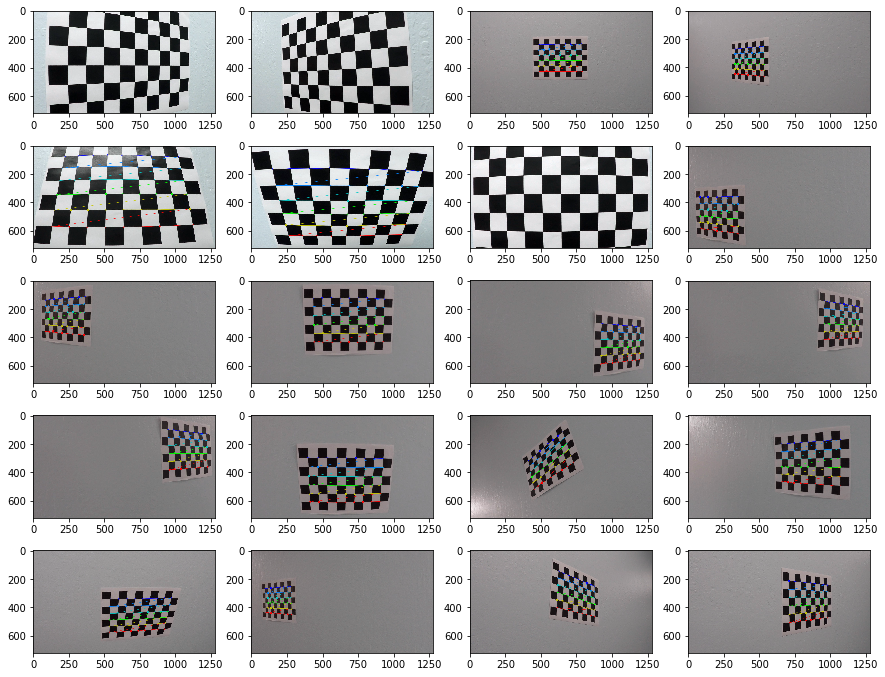

<Figure size 1080x0 with 0 Axes>

In [54]:
# Call function which performs camera calibration
# Path to images and amount of inner corners in x and y direction needs to be specified
mtx, dist, img = camera_calibration("./camera_cal", nx=9, ny=6)
print('Saving camera calibration data to pickle file')
with open('./camera_cal_parameters.pkl','wb') as f:
    pickle.dump([mtx,dist],f)

### 1.c Cam Calibration: Helper function to plot undistorted images
To validate successful calibration of camera, all chessboard calibration photos are read in again. Undistorted versions of these files are being calculated and stored in `./output_images/undist_*.jpg` 

In [4]:
# Function to create undistorted image files from chessboard images as validation
def cam_undistort_and_show(imgdir,mtx,dist,n_samples = 4):
    print("Undistorted image files for all files are being prepared...")
    if SW_SaveData == False:
        print(n_samples," will be shown on screen.")
    elif SW_SaveData == True:
        print("NONE will be shown on screen due to data saving switch set to True.")
    # Read current directory
    files = os.listdir(imgdir)
    # Shuffle files to show different images for every execution
    random.shuffle(files)
    # Create figure and subplot axes
    if SW_SaveData == False:
        fig, axs = plt.subplots(n_samples,2)
        # Define size of figure to match amount of images
        fig.set_figwidth(15)        
        fig.set_figheight(int(15/4*1.3*n_samples)) 
    # Loop over all files in directory
    n = 0
    for file in files:
        # Only process items with ending ".jpg", thus excluding directories and other files
        if file.endswith(".jpg"):
            # Generate path to current file
            fname = os.path.join(imgdir,file)
            # Read in image (CV2: BGR instead of RGB!)
            img = cv2.imread(fname)
            # Generate undistorted image
            undistorted = cv2.undistort(img, mtx, dist, None, mtx)
            # Write image file to harddrive
            cv2.imwrite(("./output_images/cam_cal/undist_"+file),undistorted)
            # Generate image output only for specified amount of images (n_samples)
            if ((n < n_samples) & (SW_SaveData == False)):
                # Show images on screen
                axs[n,0].imshow(img)
                axs[n,1].imshow(undistorted)
                n = n + 1
        else:
            continue
    if SW_SaveData == False:
        # Add title to columns 
        axs[0,0].set_title('Original Images', fontsize=15)
        axs[0,1].set_title('Undistorted Images', fontsize=15)
    print("DONE.")

### 1.d Cam Calibration: Plot original and undistorted images

TESTING IMAGE UNDISTORTION
Undistorted image files for all files are being prepared...
8  will be shown on screen.
DONE.


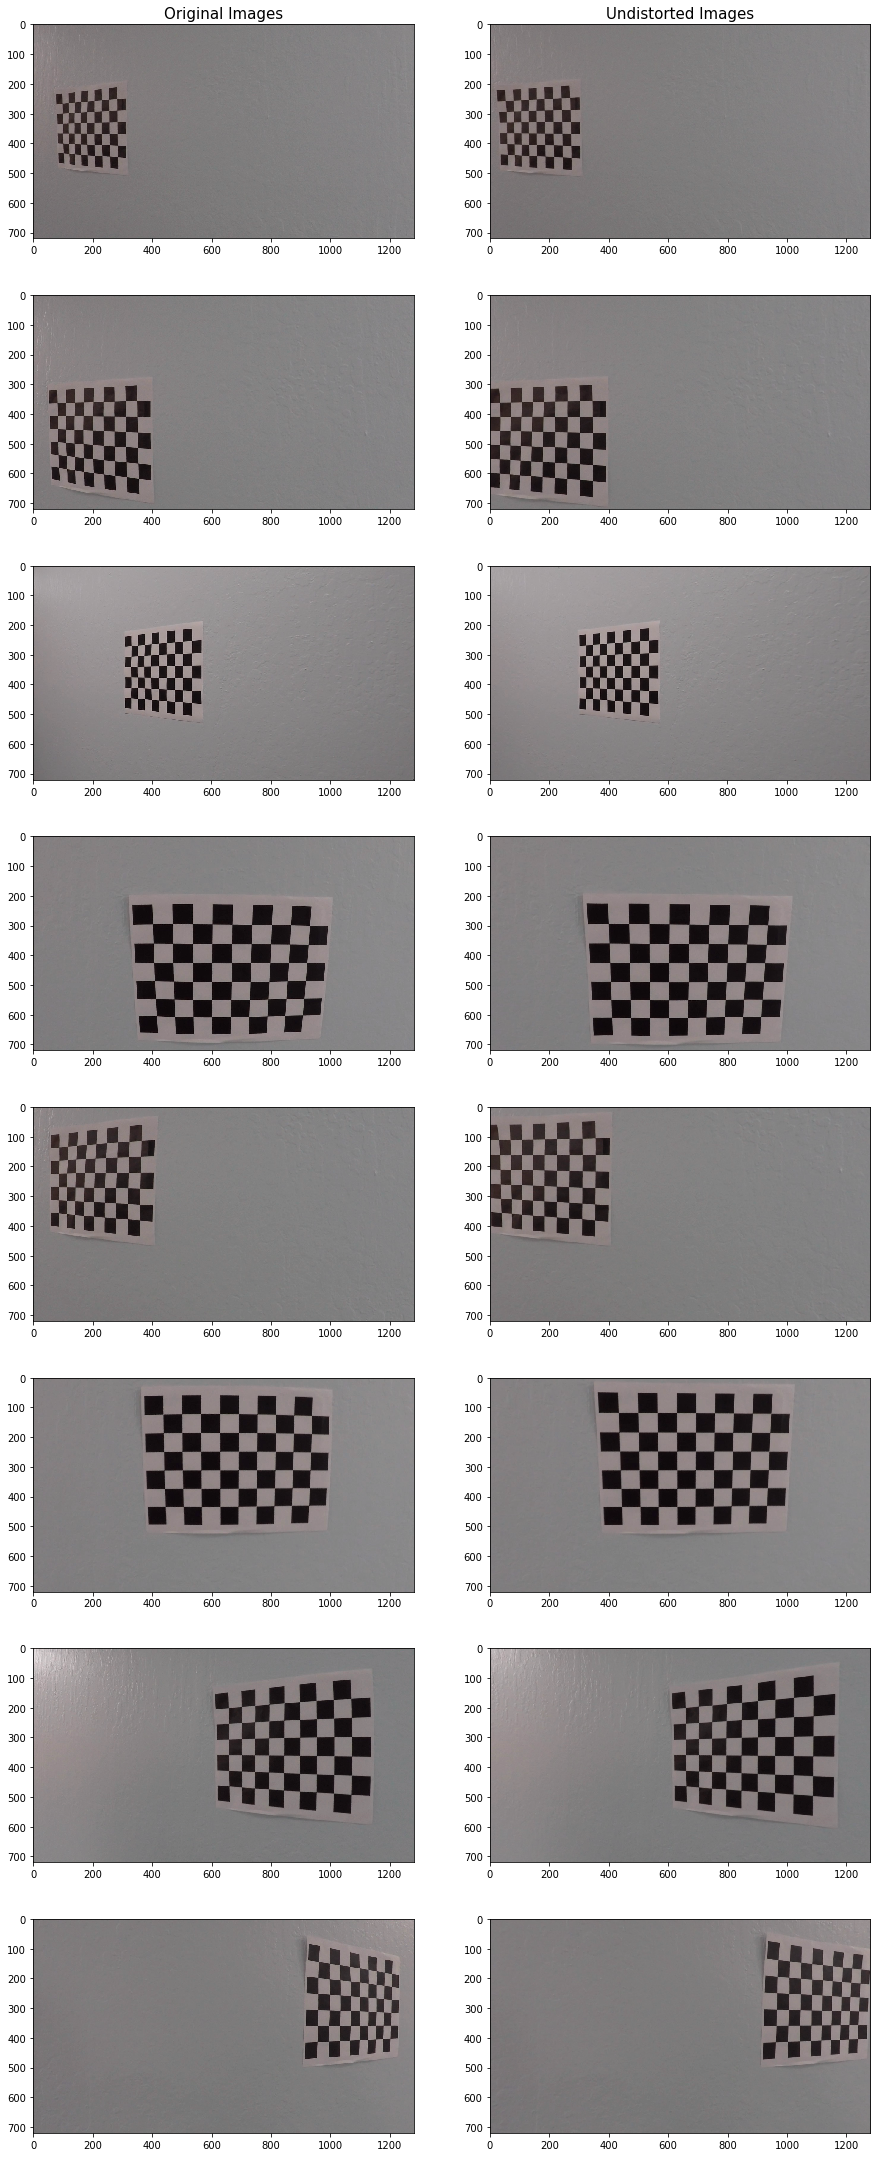

In [5]:
print("TESTING IMAGE UNDISTORTION")
cam_undistort_and_show("./camera_cal",mtx,dist,n_samples=8)

### 1.e Cam Calibration: Clean up and close all figures

In [6]:
plt.close('all')
print("All figures closed.")

All figures closed.


## Step 2: Define pipeline on test image dataset
In this step, a pipeline is being developed. The pipeline will be applied to images located in the folder `./test_images`.
Basis for the pipeline is some code, which was already developed for the 1st project of the Udacity SDC Nanodegree.


### 2.a Pipeline: Helper functions

In [7]:
import math

def readimage(filename):
    # Read image file using mpimg (ensuring RGB color space)
    return mpimg.imread(filename)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    # Applies the Canny transform
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    # Applies a Gaussian Noise kernel
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    # Applies an image mask.
    #
    # Only keeps the region of the image defined by the polygon
    # formed from `vertices`. The rest of the image is set to black.
    #
    # Defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


def filter_colors_hls(img_rgb):
    # Conversion to HLS colour space to separate white and yellow
    img_hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
    
    # Detect yellow areas (on HLS image)
    # Hue: [0...180], Lightness: [0...255], Saturation: [0...255] 
    #yellow_dark = np.array([20, 102, 80], dtype=np.uint8)   # [40, 30%, 31%]
    #yellow_light = np.array([40, 200, 255], dtype=np.uint8) # [80, 78%, 100%]
    yellow_dark = np.array([12, 123, 51], dtype=np.uint8)   # [25, 50%, 20%]
    yellow_light = np.array([45, 255, 255], dtype=np.uint8) # [90, 100%, 100%]
    yellows = cv2.inRange(img_hls, yellow_dark, yellow_light)

    # Detect white areas (on RGB image)
    white_dark = np.array([100, 100, 200], dtype=np.uint8)
    white_light = np.array([255, 255, 255], dtype=np.uint8)
    whites = cv2.inRange(img_rgb, white_dark, white_light)
    
    # Combine information to a mask and apply to image
    yellows_or_whites = yellows | whites
    img_colmasked = cv2.bitwise_and(img_rgb, img_rgb, mask=yellows_or_whites)
    
    # Convert back to RGB
#    img_out = cv2.cvtColor(img_colmasked, cv2.COLOR_HLS2RGB)
    img_out = img_colmasked
    return (img_out,yellows_or_whites)
print("Reading of helper functions DONE.")

Reading of helper functions DONE.


### 2.b Pipeline: Find best color map for thresholding

In [8]:
# Color Channels Plot function definition
def plot_color_channels(img_rgb,filename):
    img_hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    fig, axs = plt.subplots(4,3)
    fig.set_figwidth(15)
    fig.set_figheight(14)
    fig.suptitle(filename, fontsize=20)
    axs[0,0].imshow(img_rgb)
    axs[0,0].set_title('Original RGB image')
    axs[0,1].imshow(grayscale(img_rgb),cmap='gray')
    axs[0,1].set_title('GRAYSCALE image')
    axs[0,2].imshow(np.zeros_like(img_rgb)+254,cmap='gray')
    axs[0,2].set_title('none')
    axs[1,0].imshow(img_rgb[:,:,0],cmap='gray')
    axs[1,0].set_title('RGB RED Channel')
    axs[1,1].imshow(img_rgb[:,:,1],cmap='gray')
    axs[1,1].set_title('RGB GREEN Channel')
    axs[1,2].imshow(img_rgb[:,:,2],cmap='gray')
    axs[1,2].set_title('RGB BLUE Channel')
    axs[2,0].imshow(img_hsv[:,:,0],cmap='gray')
    axs[2,0].set_title('HSV HUE Channel')
    axs[2,1].imshow(img_hsv[:,:,1],cmap='gray')
    axs[2,1].set_title('HSV SATURATION Channel')
    axs[2,2].imshow(img_hsv[:,:,2],cmap='gray')
    axs[2,2].set_title('HSV VALUE Channel')
    axs[3,0].imshow(img_hls[:,:,0],cmap='gray')
    axs[3,0].set_title('HLS HUE Channel')
    axs[3,1].imshow(img_hls[:,:,1],cmap='gray')
    axs[3,1].set_title('HLS LIGHTNESS Channel')
    axs[3,2].imshow(img_hls[:,:,2],cmap='gray');
    axs[3,2].set_title('HLS SATURATION Channel');
    # Draw, save and close figure
    plt.draw();
    plt.savefig("./output_images/thresholding/col_chans_"+filename);
    plt.close();
# Confirm successful finish
print("Reading of helper functions DONE.")

Reading of helper functions DONE.


In [9]:
# Read in sample image files
basepath = "./test_images/"
files = os.listdir(basepath)
# Print number of files
print(np.size(files), "image files found.")
print("Output will be written to './output_images/thresholding/col_chans_*.jpg'")
# Process each image file
for file in files:
    fullfile = basepath+file
    print("...processing",fullfile)
    # Read image file
    img_rgb = readimage(fullfile)
    # Create undistorted image
    img_rgb = cv2.undistort(img_rgb, mtx, dist, None, mtx)
            
    # Plot image file with samples for every color channel 
    # in RGB, GRAY, HSV and HSL color space
    plot_color_channels(img_rgb,file)
# Confirm successful finish
print("DONE.")

8 image files found.
Output will be written to './output_images/thresholding/col_chans_*.jpg'
...processing ./test_images/test6.jpg
...processing ./test_images/test5.jpg
...processing ./test_images/test4.jpg
...processing ./test_images/test1.jpg
...processing ./test_images/test3.jpg
...processing ./test_images/test2.jpg
...processing ./test_images/straight_lines2.jpg
...processing ./test_images/straight_lines1.jpg
DONE.


### 2.c Pipeline: Threshold image
Based on different color space analysis, several ideas were developed:
* HSV color space is showing lane line attributes less clearly and will be ignored
* Saturation of HLS color space shows many lane line attributes with high contrast. However...
    * Issue 1: false readings are likely occuring in shadows on the road, which seem to have similar saturation values (e.g. test4.jpg). Strategy to exclude these areas is to make use of the Hue channel:
        * hue is nearly black for all lane lines 
        * hue is nearly white for the shadow areas
        * thus, limiting HLS Hue to lower values solves this issue.
    * Issue 2: more adjacent lane lines tend to disappear. Solution:
        * regular grayscale image shows highest contrast for these lane line fragments
        * however, grayscale image shows lots of fragments nearby areas, where HLS Saturation otherwise performs excellent, which would affect the pipelines performance negatively
        * therefore, more weight will be applied to HLS Saturation channel to make the overall detection more robust


In [10]:
# TODO: add HUE filter to grayscale image
img_hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
def thresholding(img_rgb,filename):
    # First: process HLS color space information
    # Convert image to Grayscale and to HLS color space
    img_hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
    img_h = img_hls[:,:,0]
    img_l = img_hls[:,:,1]
    img_s = img_hls[:,:,2]
    # Define threshold values on HLS image: 
    # only accept low Hue values and high staturation values. Saturation is ignored
    HUE = [0,80]
    LIGHTNESS = [0,255]
    SATURATION = [150,255]
    # Transform threshold values to necessary data type
    lim_lo = np.array([HUE[0], LIGHTNESS[0], SATURATION[0]], dtype=np.uint8)
    lim_hi = np.array([HUE[1], LIGHTNESS[1], SATURATION[1]], dtype=np.uint8)
    # Apply threshold to HLS image
    mask_h = np.zeros_like(img_h)
    mask_h[(img_h >= HUE[0])        & (img_h <= HUE[1])] = 1
    mask_l = np.zeros_like(img_l)
    mask_l[(img_l >= LIGHTNESS[0])  & (img_l <= LIGHTNESS[1])] = 1
    mask_s = np.zeros_like(img_s)
    mask_s[(img_s >= SATURATION[0]) & (img_s <= SATURATION[1])] = 1
    mask_hls = mask_h & mask_l & mask_s

    img_masked_hls = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_hls)
    
    
    # SECOND: process grayscale information
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)    
    # Detect white areas (on GRAYSCALE image)
    lim_lo = np.array([100], dtype=np.uint8)
    lim_hi = np.array([255], dtype=np.uint8)
    # Apply threshold to Grayscale image
    mask_gray = cv2.inRange(img_gray, lim_lo, lim_hi)
    # Apply masks to images
    img_masked_gray = cv2.bitwise_and(img_gray, img_gray, mask=mask_gray)
    # Apply sobel x gradient detection on masked grayscale image
    sobelx = cv2.Sobel(img_masked_gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold sobel x gradient
    sx_thresh = [30,255]
    mask_sx = np.zeros_like(scaled_sobel)
    mask_sx[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    img_masked_sx = cv2.bitwise_and(img_gray, img_gray, mask=mask_sx)

    # THIRD: Stack all channels
    color_binary = np.dstack((mask_hls, mask_sx, np.zeros_like(mask_sx))) * 255
    # Create combined B/W image
    bw_binary = np.zeros_like(mask_hls)
    bw_binary[(mask_hls == 1) | (mask_sx == 1)] = 1    

    # Plot images
    fig, axs = plt.subplots(6,2)
    fig.set_figwidth(15)
    fig.set_figheight(20)
    fig.suptitle(filename, fontsize=20)
    axs[0,0].imshow(img_rgb)
    axs[0,0].set_title('Original RGB image')
    axs[0,1].imshow(grayscale(img_rgb),cmap='gray')
    axs[0,1].set_title('GRAYSCALE image')
    axs[1,0].imshow(img_hls[:,:,0],cmap='gray')
    axs[1,0].set_title('HLS HUE Channel')
    axs[1,1].imshow(img_hls[:,:,2],cmap='gray')
    axs[1,1].set_title('HLS LIGHTNESS Channel')
    axs[2,0].imshow(mask_gray,cmap='gray')
    axs[2,0].set_title('GRAY mask')
    axs[2,1].imshow(img_masked_gray,cmap='gray')
    axs[2,1].set_title('GRAY masked image')
    axs[3,0].imshow(mask_sx,cmap='gray')
    axs[3,0].set_title('Sobel_x mask')
    axs[3,1].imshow(img_masked_sx,cmap='gray')
    axs[3,1].set_title('Sobel_x masked image')
    axs[4,0].imshow(mask_hls,cmap='gray')
    axs[4,0].set_title('HLS mask')
    axs[4,1].imshow(img_masked_hls)
    axs[4,1].set_title('HLS masked image')
    axs[5,0].imshow(bw_binary,cmap='gray')
    axs[5,0].set_title('BW binary')
    axs[5,1].imshow(color_binary)
    axs[5,1].set_title('Color binary image (r:sx, g:HLS)')
    # Draw, save and close figure
    plt.draw();
    plt.savefig("./output_images/thresholding/thresh_hls_gray_"+filename);
    plt.close();
    # Return all information
    return (color_binary,bw_binary)    

# Confirm successful finish
print("Reading of helper functions DONE.")
    

Reading of helper functions DONE.


Thresholding images with HLS and Grayscale color space
8 image files found.
Output will be written to './output_images/thresholding/thresh_hls_gray_*.jpg'
...processing ./test_images/test6.jpg
...processing ./test_images/test5.jpg
...processing ./test_images/test4.jpg
...processing ./test_images/test1.jpg
...processing ./test_images/test3.jpg
...processing ./test_images/test2.jpg
...processing ./test_images/straight_lines2.jpg
...processing ./test_images/straight_lines1.jpg
DONE.


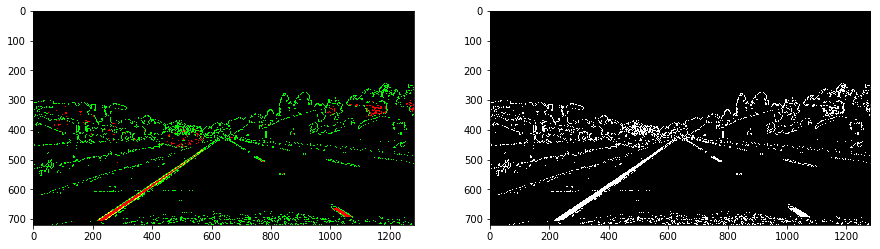

In [11]:
# Read in sample image files
basepath = "./test_images/"
files = os.listdir(basepath)
# Print number of files
print("Thresholding images with HLS and Grayscale color space")
print(np.size(files), "image files found.")
print("Output will be written to './output_images/thresholding/thresh_hls_gray_*.jpg'")
# Process each image file
for file in files:
    fullfile = basepath+file
    print("...processing",fullfile)
    # Read image file
    img_rgb = readimage(fullfile)
    # Create undistorted image
    img_rgb = cv2.undistort(img_rgb, mtx, dist, None, mtx)
    # Plot image file with samples for every color channel 
    # in RGB, GRAY, HSV and HSL color space
    color_binary, bw_binary = thresholding(img_rgb,file);
# Confirm successful finish
f = plt.figure(figsize=(15,10))
ax1 = f.add_subplot(121)
ax1.imshow(color_binary); 
ax2 = f.add_subplot(122)
ax2.imshow(bw_binary,cmap='gray');
# plt.show()
print("DONE.")

### 2.d Pipeline: Perspective transform
Based on different color space analysis, several ideas were developed:
* HSV color space is showing lane line attributes less clearly and will be ignored: only RGB/GRAY and HLS color space will be used
* Saturation of HLS color space shows many lane line attributes with high contrast. However...
    * Issue 1: false readings are likely occuring in shadows on the road, which seem to have similar saturation values (e.g. test4.jpg). Strategy to exclude these areas is to make use of the Hue channel:
        * hue is nearly black for all lane lines 


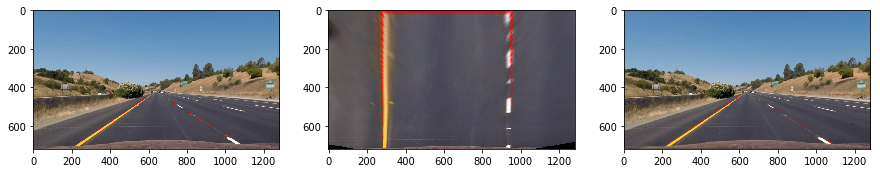

In [56]:
def perspective_transform(img):
    img2 = np.copy(img)
    img = np.copy(img)
    pts = np.array([[188,720],[594,450],[686,450],[1125,720]], np.int32)
    pts = pts.reshape((-1,1,2))
    src = np.float32(pts)
    dst = np.float32([[280,720],[280,0],[950,0],[950,720]])

    # Draw polygon
    cv2.polylines(img2,[pts],True,(255,0,0),1)

    #Compute the perspective transform, M, given source and destination points:
    #M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse perspective transform:
    #Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp an image using the perspective transform, M:
    #warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Perform perspective transform
    M_transform = cv2.getPerspectiveTransform(src,dst)
    # print(np.shape(M_transform))
    # print(M_transform)
    img_warped =  cv2.warpPerspective(img,M_transform,(img.shape[1],img.shape[0]))
    img_warped2 =  cv2.warpPerspective(img2,M_transform,(img2.shape[1],img2.shape[0]))
    return (img_warped, img2, img_warped2)

def perspective_transform_back(img):
    img2 = np.copy(img)
    img = np.copy(img)
    pts = np.array([[188,720],[594,450],[686,450],[1125,720]], np.int32)
    pts = pts.reshape((-1,1,2))
    src = np.float32(pts)
    dst = np.float32([[280,720],[280,0],[950,0],[950,720]])
    
    # Perform perspective transform
    M_transform = cv2.getPerspectiveTransform(dst,src)

    # Warp image
    img_warped =  cv2.warpPerspective(img,M_transform,(img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    return (img_warped)



# Call perspective transform helper function
img_warped, img_rgb_boundary, img_warped_boundary = perspective_transform(img_rgb)
img_warped_back = perspective_transform_back(img_warped_boundary)
img_warped_back2 = np.copy(img_rgb)
img_warped_back2[img_warped_back.nonzero()] = img_warped_back[img_warped_back.nonzero()]
    
# Plot images
fig,ax = plt.subplots(1,3)
fig.set_figwidth(15)
fig.set_figheight(4)
ax[0].imshow(img_rgb_boundary)
ax[1].imshow(img_warped_boundary)
ax[2].imshow(img_rgb)
ax[2].imshow(img_warped_back)
ax[2].imshow(img_warped_back2)
#ax[0].imshow(img_rgb)
#ax[1].imshow(img_warped)
plt.draw()
plt.show()


### 2.e Pipeline: Detect lane pixels and fit to find the lane boundary.
asdf:
* asdf
* asdf
    * asdf
        * asdf


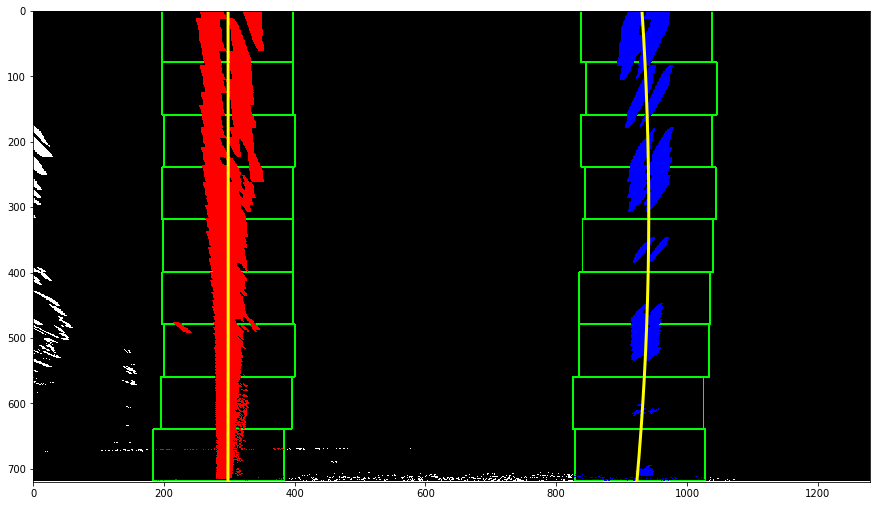

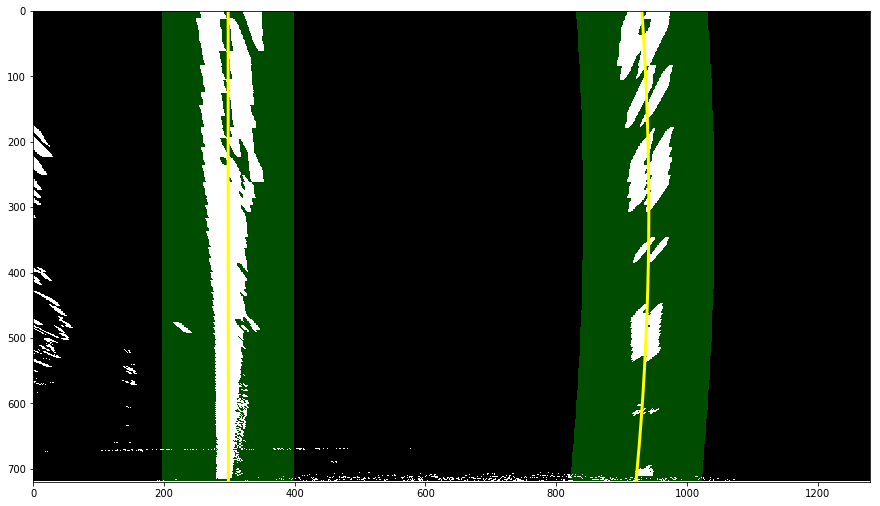

In [48]:
def sliding_windows(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    
    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    
    
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    fig = plt.figure()
    fig.set_figwidth(15)    
    fig.set_figheight(11)    
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow', linewidth=3)
    plt.plot(right_fitx, ploty, color='yellow', linewidth=3)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    
    
    
    
    
    
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    

    
    
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    out_img2 = np.dstack((binary_warped, binary_warped, binary_warped))*255
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img2, 1, window_img, 0.3, 0)
    fig = plt.figure()
    fig.set_figwidth(15)    
    fig.set_figheight(11)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow', linewidth=3)
    plt.plot(right_fitx, ploty, color='yellow', linewidth=3)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    
    return (left_fit,right_fit,left_fit_m,right_fit_m,out_img)
   
    
    
bw_warped = perspective_transform(bw_binary)[0]    
left_fit, right_fit, left_fit_m, right_fit_m, out_img = sliding_windows(bw_warped)

### 2.f Pipeline: Detect curvature and position relative to center
asdf:
* asdf
* asdf
    * asdf
        * asdf

In [14]:
print(left_fit)
print(np.shape(bw_warped)[0])

[ 1.29312892e-06 -3.68618480e-04  2.98331660e+02]
720


In [44]:
# TODO: update lane conversion factors to own images (dashed lanes 3.7m wide, 3m long)
def curve_radius(left_fit,right_fit,left_fit_m, right_fit_m, img):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.shape(img)[0]
    
    # Calculate curve radius in PIXEL space
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print("Curve radius [pixels]:",int(left_curverad),"pix (left),", int(right_curverad),"pix (right)")

    # Conversion factors for pixels to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Calculate curve radius in METRIC space
    left_curverad_m = \
    ((1 + (2*left_fit_m[0]*y_eval*ym_per_pix + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
    right_curverad_m = \
    ((1 + (2*right_fit_m[0]*y_eval*ym_per_pix + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])
    print("Curve radius [meter]:",int(left_curverad_m),"m (left),",int(right_curverad_m),"m (right)")
    
def veh_position(left_fit, right_fit, img):
    # Calculate vehicle position
    y_val = img.shape[0]-1
    left_x = left_fit[0]*y_val**2 + left_fit[1]*y_val + left_fit[2]
    right_x = right_fit[0]*y_val**2 + right_fit[1]*y_val + right_fit[2]
    
    x_dim = img.shape[1]-1
    x_veh_ctr = x_dim*0.5
    
    x_lane_pos = left_x + 0.5*(right_x - left_x)
    
    x_dist = x_veh_ctr - x_lane_pos
    print("Distance in pix:",x_dist)
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    x_dist_m = x_dist * xm_per_pix
    print("Distance in meter:",x_dist_m)
    return(x_dist_m)


curve_radius(left_fit,right_fit,left_fit_m,right_fit_m,out_img)
x_dist_m = veh_position(left_fit,right_fit,img)

Curve radius [pixels]: 386660 pix (left), 4432 pix (right)
Curve radius [meter]: 62215 m (left), 1520 m (right)
Distance in pix: 29.075346687488945
Distance in meter: 0.15368397534815587


### 2.g Pipeline: Warp back to original image
asdf:
* asdf
* asdf
    * asdf
        * asdf
Warp the detected lane boundaries back onto the original image.
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

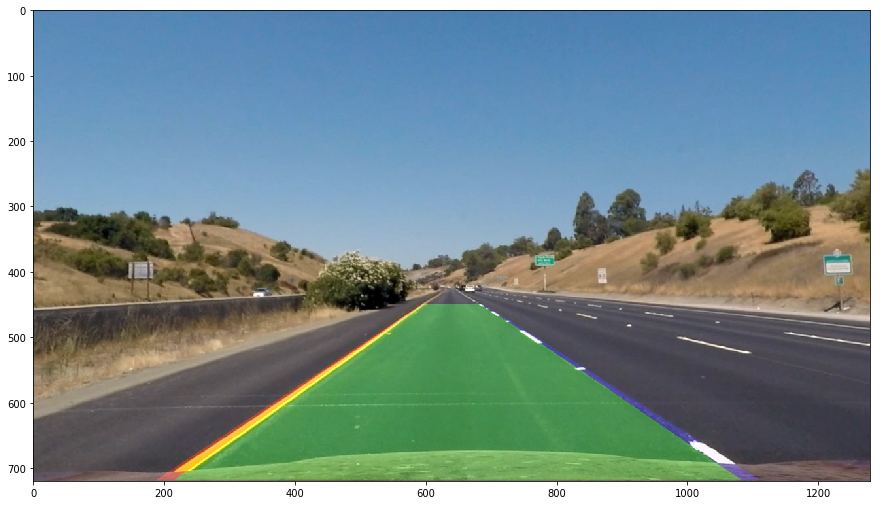

In [45]:
def output_to_warp_back(left_fit,right_fit,img):
    # Prepare empty image to draw onto
    out_img = np.zeros_like(img)
    
    # Generate x and y values for plotting
    margin = 20
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    # Generate a polygon to show lane line
    
    # Prepare polygon information for cv2 fillpoly function
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx,ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])    
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    lane_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    lane_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])    
    lane_window_pts = np.hstack((lane_window1,lane_window2))
    
    # Plot polygons onto empty output image
    cv2.fillPoly(out_img, np.int_([left_line_pts]), (255, 0, 0))
    cv2.fillPoly(out_img, np.int_([right_line_pts]), (0, 0, 255))
    cv2.fillPoly(out_img, np.int_([lane_window_pts]), (0,255 , 0))
    
    # Generate combined image
#     result = cv2.addWeighted(img, 1, out_img, 0.3, 0)    

    # Return image file with overlay
    return (out_img)


out_img2 = output_to_warp_back(left_fit,right_fit,out_img)
    
out_img_warped_back = perspective_transform_back(out_img2)
out_img_warped_back2 = cv2.addWeighted(img_rgb, 1, out_img_warped_back, 0.3, 0)    

fig = plt.figure()
fig.set_figwidth(15)    
fig.set_figheight(11)

plt.imshow(out_img_warped_back2);
# plt.imshow(out_img2);
# plt.imshow(out_img);

### 2.h Pipeline: Output visual display of lane boundaries 
asdf:
* asdf
* asdf
    * asdf
        * asdf

(720, 1280, 3)


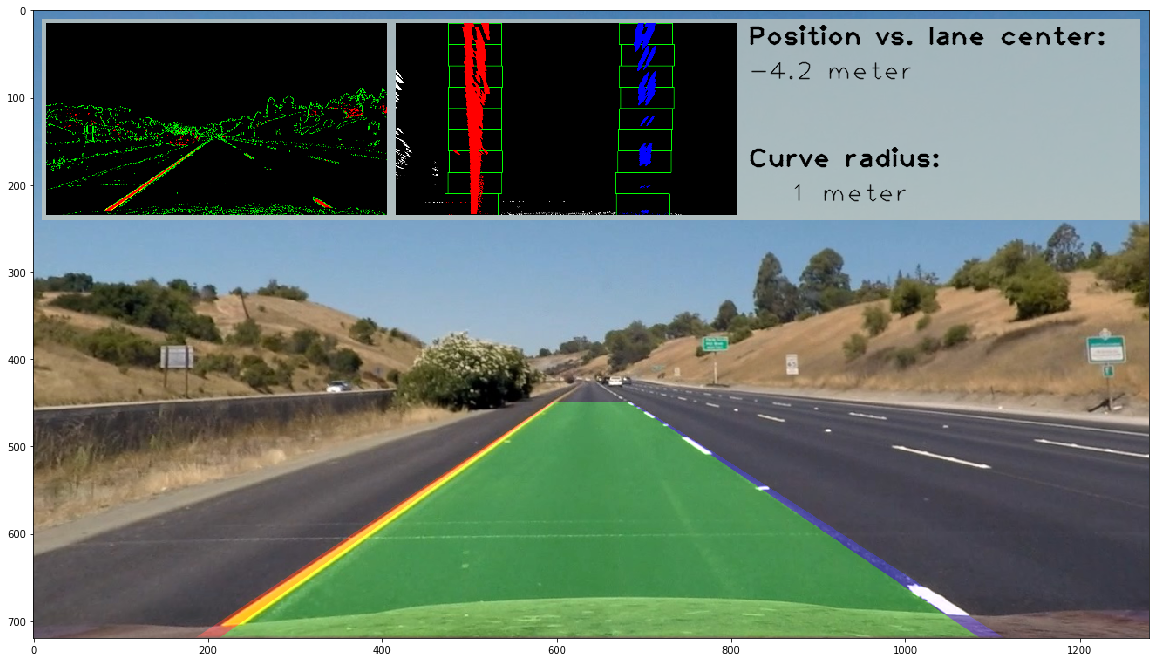

In [49]:
# def plot_additional_info(img,img_bw,img_lanes):
def plot_additional_info(img,sub_img1,sub_img2):
    img_add = np.zeros_like(img)
    vid_add1 = np.zeros_like(img)
    vid_add2 = np.zeros_like(img)
    out_img = np.copy(img)
    print(np.shape(img_add))
    
    # Define points for drawing frame, segmentation images and text
    pts_frame = np.array([[10,10],[10,240],[np.shape(img)[1]-11,240],[np.shape(img)[1]-11,10]], np.int32)
    pts_img1 = np.array([[15,15],[15,235],[406,235],[406,15]], np.int32)
    pts_img2 = np.array([[416,15],[416,235],[807,235],[807,15]], np.int32)
    
    # Fill areas
    cv2.fillPoly(img_add, [pts_frame], (156,158,148))
    cv2.fillPoly(vid_add1, [pts_img1], (1,1,1))
    cv2.fillPoly(vid_add2, [pts_img2], (1,1,1))
    
    # Prepare mini video overlay
    sub_img1s = cv2.resize(sub_img1, (391, 220)) 
    sub_img2s = cv2.resize(sub_img2, (391, 220)) 

    
    # Draw grayish frame on image
    inds = img_add.nonzero();
    overlay = cv2.addWeighted(out_img, 0.3, img_add, 0.9, 0)    
    out_img[inds] = overlay[inds]
    
    # Draw segmentation images / videos on image
    inds = vid_add1.nonzero();
    out_img[pts_img1[0,1]:pts_img1[2,1],pts_img1[0,0]:pts_img1[2,0]] = sub_img1s
    out_img[pts_img2[0,1]:pts_img2[2,1],pts_img2[0,0]:pts_img2[2,0]] = sub_img2s
#     out_img[inds] = vid_add[inds]
#     out_img[inds] = sub_img1s
#     inds = vid_add2.nonzero();
#     out_img[inds] = vid_add2[inds]
    
    # Overlay text
    fontface = cv2.FONT_HERSHEY_DUPLEX
    fontface2 = cv2.FONT_HERSHEY_COMPLEX_SMALL
    fontcolor = (0,0,0)
    fontscale = 0.5
    linetype = cv2.LINE_AA
    cv2.putText(out_img,'Position vs. lane center: ',(820,40),1,fontface,fontcolor,2,linetype)
    cv2.putText(out_img,"%+1.1F meter" %(-4.2),(820,80),1,fontface,fontcolor,1,linetype)
    cv2.putText(out_img,'Curve radius: ',(820,180),1,fontface,fontcolor,2,linetype)
    cv2.putText(out_img,"%4d meter" %(1),(820,220),1,fontface,fontcolor,1,linetype)
    
    
    # Show final image 
    fig = plt.figure()
    fig.set_figwidth(20)    
    fig.set_figheight(15)
    plt.imshow(out_img)

plot_additional_info(out_img_warped_back2,color_binary,out_img)
    
    

In [35]:
pts_img1 = np.array([[15,15],[15,235],[406,235],[406,15]], np.int32)
pts_img2 = np.array([[411,15],[411,235],[802,235],[802,15]], np.int32)

In [29]:
print(pts_img1[1])
print(pts_img1[1,1])
print(pts_img1[1,0])
print(pts_img1[1][1])
print(pts_img1)

[ 15 235]
235
15
235
[[ 15  15]
 [ 15 235]
 [406 235]
 [406  15]]


In [32]:
print(pts_img1[0,1],pts_img1[2,1],pts_img1[0,0],pts_img1[2,0])
print(pts_img2[0,1],pts_img2[2,1],pts_img2[0,0],pts_img2[2,0])

15 235 15 406
15 235 411 802
